In [1]:
from scipy import ndimage
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

In [2]:
nifti_file = nib.load(r"C:\Users\s9554\Downloads\CT-0\study_0100.nii.gz")

In [4]:
img = nifti_file.get_fdata()

In [7]:
img.shape

(512, 512, 41)

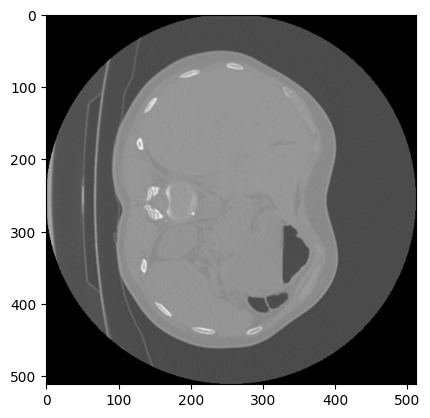

In [12]:
plt.imshow(img[:, :, 10], cmap = 'grey')

In [2]:
data_path_normal = r"C:\Users\s9554\Downloads\CT-0"
data_path_abnormal = r"C:\Users\s9554\Downloads\CT-23"

list_normal = os.listdir(data_path_normal)
# list_normal = np.array(list_normal).reshape(100, 1)
list_abnormal = os.listdir(data_path_abnormal)
# list_abnormal = np.array(list_abnormal).reshape(100, 1)

label_normal = np.ones((100, 1))
label_abnormal = np.zeros((100, 1))

In [3]:
def process_data_normal(file):
    nifti_file = os.path.join(data_path_normal, file)
    img = nib.load(nifti_file)
    img = img.get_fdata()

    #normalization
    min = -1000
    max = 400
    img[img < min] = min
    img[img > max] = max
    img = (img - min) / (max - min)
    img = img.astype(np.float32)

    #resize
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)

    return img

def process_data_abnormal(file):
    nifti_file = os.path.join(data_path_abnormal, file)
    img = nib.load(nifti_file)
    img = img.get_fdata()

    #normalization
    min = -1000
    max = 400
    img[img < min] = min
    img[img > max] = max
    img = (img - min) / (max - min)
    img = img.astype(np.float32)

    #resize
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)

    return img

In [4]:
normal_data = np.array([process_data_normal(data) for data in list_normal])
abnormal_data = np.array([process_data_abnormal(data) for data in list_abnormal])

In [5]:
x_train = np.concatenate((normal_data[: 80], abnormal_data[: 80]))
y_train = np.concatenate((label_normal[: 80], label_abnormal[: 80]))

x_val = np.concatenate((normal_data[80: ], abnormal_data[80: ]))
y_val = np.concatenate((label_normal[80: ], label_abnormal[80: ]))

In [6]:
def final_process(img, label):
    return tf.expand_dims(img, axis = 3), label

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_data = (
    train_data.map(final_process, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(2)
    .prefetch(tf.data.AUTOTUNE)
)
val_data = (
    val_data.map(final_process, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(2)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)

(2, 128, 128, 64, 1)
(2, 1)


In [9]:
def get_model(width=128, height=128, depth=64):

    inputs = tf.keras.Input((width, height, depth, 1))

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    return model

model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 126, 126, 62,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 31, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 29, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 6, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 6, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 4, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 2, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [10]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

In [ ]:
his = model.fit(
    train_data, epochs = 2, validation_data = val_data
)

Epoch 1/2
54/80 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - acc: 0.9032 - loss: 0.4964